In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
from scipy import stats
import mysql.connector
import seaborn as sns

In [83]:
username = 'root'
user_password = 'Sadegh74'
db_name = 'superstore'

In [84]:
cnx = mysql.connector.connect(
    user=username,
    password=user_password,
    host='localhost',
    database=db_name
)

In [85]:
query = "SELECT * FROM order_detail;"
df = pd.read_sql(query, con=cnx)
df.head()

,Row ID,Order ID,Product ID,Sales,Quantity,Discount,Profit,Shipping Cost
0,1,MX-2014-143658,OFF-LA-10002782,13.08,3,0.0,4.56,1.033
1,2,MX-2012-155047,FUR-FU-10004015,252.16,8,0.0,90.72,13.449
2,3,MX-2012-155047,FUR-BO-10002352,193.28,2,0.0,54.08,9.627
3,4,MX-2012-155047,OFF-BI-10004428,35.44,4,0.0,4.96,1.371
4,5,MX-2012-155047,OFF-AR-10004594,71.60,2,0.0,11.44,3.787


In [87]:
w_dis = df[df['Discount'] != 0]
wo_dis = df[df['Discount'] == 0]

In [88]:
w = w_dis.groupby('Product ID')['Quantity'].sum().reset_index()
wo = wo_dis.groupby('Product ID')['Quantity'].sum().reset_index()
col_name = ['Product ID','Quantity']
w.columns = col_name
wo.columns = col_name
wo = wo[wo['Product ID'].isin(w['Product ID'])].sort_values(by='Product ID')
w = w[w['Product ID'].isin(wo['Product ID'])].sort_values(by='Product ID')
Discount_df = pd.merge(w, wo, on='Product ID', how='inner')
col_name = ['Product ID','with_discount','without_discount']
Discount_df.columns = col_name
Discount_df['dif'] = Discount_df['with_discount'] - Discount_df['without_discount']
Discount_df

,Product ID,with_discount,without_discount,dif
0,FUR-ADV-10000183,20,11,9
1,FUR-ADV-10000188,3,4,-1
2,FUR-ADV-10001283,2,1,1
3,FUR-ADV-10001659,2,8,-6
4,FUR-ADV-10001855,1,3,-2
...,...,...,...,...
6533,TEC-STA-10003447,1,7,-6
6534,TEC-STA-10003550,1,13,-12
6535,TEC-STA-10003925,2,6,-4
6536,TEC-STA-10004181,1,10,-9


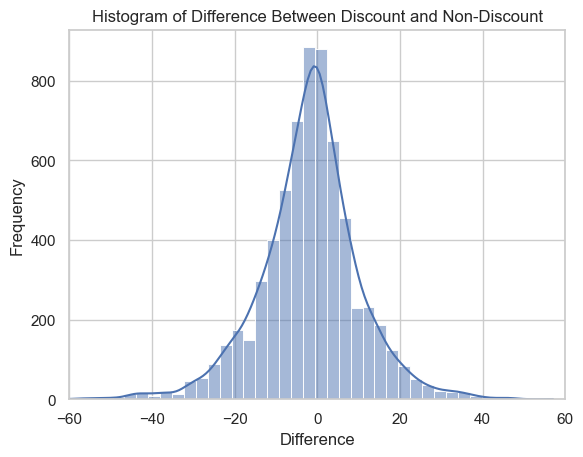

In [89]:
sns.histplot(Discount_df['dif'], bins=50, kde=True)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Difference Between Discount and Non-Discount')
plt.xlim(xmin=-60, xmax=60)
plt.savefig('Histogram.png')
plt.show()

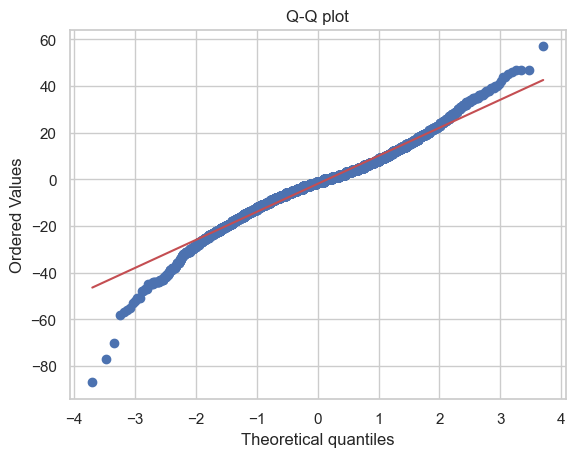

In [90]:
stats.probplot(Discount_df['dif'], dist="norm", plot=plt)
plt.title("Q-Q plot")
plt.show()

In [91]:
t_statistic, p_value = stats.ttest_1samp(Discount_df['dif'], 0)

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


In [92]:
w_statistic, p_value = stats.wilcoxon(Discount_df['dif'])
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


In [94]:
Stats_Results = {}
Stats_Results['No. Discounted Products'] = len(Discount_df)
Stats_Results['Hypothesis'] = 'The average quantity of discounted orders is same to the average quantity of non-discounted orders.'
Stats_Results['t_statistic'] = t_statistic
Stats_Results['p_value'] = p_value
Stats_Results['Confidence Level'] = (1- alpha)*100
Stats_Results['Result'] = 'Discounts affect sales.' if p_value < alpha else 'The discount does not affect the sale.'
Stats_Results = pd.DataFrame(Stats_Results, index=[0])
Stats_Results

,No. Discounted Products,Hypothesis,t_statistic,p_value,Confidence Level,Result
0,6538,The average quantity of discounted orders is s...,-12.574933,1.845384e-36,95.0,Discounts affect sales.
